In [509]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [ ]:
circuits = pd.read_csv("../data/circuits.csv")
constructors = pd.read_csv("../data/constructors.csv")
drivers = pd.read_csv("../data/drivers.csv")
qualification = pd.read_csv("../data/qualifying.csv")
races = pd.read_csv("../data/races.csv")
results = pd.read_csv("../data/results.csv")
seasons = pd.read_csv("../data/seasons.csv")

In [ ]:
#merge files

dataframe_1 = pd.merge(drivers,qualification,how='inner', on=['driverId'])
dataframe_2 = pd.merge(dataframe_1, results, how="inner", on =["driverId", "raceId", "constructorId"])
dataframe_3 = pd.merge(dataframe_2, constructors, how="inner", on=["constructorId"])
dataframe_4 = pd.merge(dataframe_3, races, how="inner", on=['raceId'])
dataframe_5 = pd.merge(dataframe_4, circuits, how="inner", on=["circuitId"])

In [ ]:
# print(dataframe_5.columns)
final_data = dataframe_5.drop(['number_x','url_x', 'qualifyId', 
       'number_y', 'q1', 'q2', 'q3', 'position_y', 'positionText', 'positionOrder', 
       'time_x', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'url_y', 'name_y', 'time_y', 'url_x',
       'lat', 'lng', 'alt', 'url_y'],axis=1)

In [ ]:

final_data.rename(columns={'name':'GP_name','position_x':'position','name_x':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
# final_data.to_csv("data_merged.csv")

In [420]:
print(final_data.columns)
#changing the names of the constructors who have changed their team names
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Astin Martin' if x=='Force India' or x=="Racing Point" else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='BMW Sauber' else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'Alpine' if x=='Lotus F1' or x=="Renault" else x)
final_data['constructor'] = final_data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)
# print(final_data["constructor"].unique())

Index(['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob',
       'driver_nationality', 'raceId', 'constructorId', 'position', 'resultId',
       'number', 'grid', 'points', 'laps', 'statusId', 'constructorRef',
       'constructor', 'constructor_nationality', 'year', 'round', 'circuitId',
       'date', 'circuitRef', 'GP_name', 'location', 'country', 'driver',
       'ageDuringRace', 'Drivers'],
      dtype='object')


In [ ]:
#Driver name
final_data["driver"] = final_data["forename"] + final_data["surname"]

In [ ]:
#Calculating the age of driver during the race
final_data["dob"] = pd.to_datetime(final_data["dob"])
final_data["date"] = pd.to_datetime(final_data["date"])
final_data["ageDuringRace"] = abs(final_data["dob"] - final_data["date"])
final_data["ageDuringRace"] = final_data["ageDuringRace"].apply(lambda x: str(x).split(" ")[0])
final_data["ageDuringRace"] = final_data["ageDuringRace"].astype("int64") #changing to int type


In [ ]:
age_vs_points = final_data[['driver', 'ageDuringRace', 'points']].copy()
age_vs_points.isnull().sum()
age_vs_points.dropna(inplace=True)
#converting to age
age_vs_points["ageDuringRace"] = age_vs_points["ageDuringRace"].apply(lambda age: age//365)

In [ ]:
# exporting the age and points for all the drivers 
#  age_vs_points.to_csv("age_vs_points.csv")


In [ ]:
age_vs_points = pd.read_csv("age_vs_points.csv")
#summing up all the points for a particular age
age = age_vs_points.ageDuringRace.unique()
points = []
for i in age:
    points.append(age_vs_points[age_vs_points["ageDuringRace"] == i].points.sum())

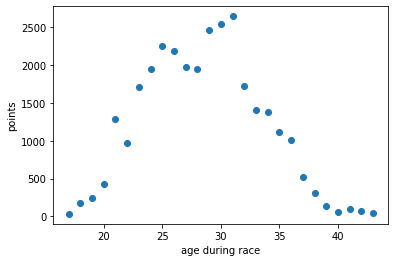

In [464]:
#correlation between age and points won during a race
x = age
y = points
plt.scatter(x, y)
plt.xlabel('age during race')
plt.ylabel("points")
plt.show()

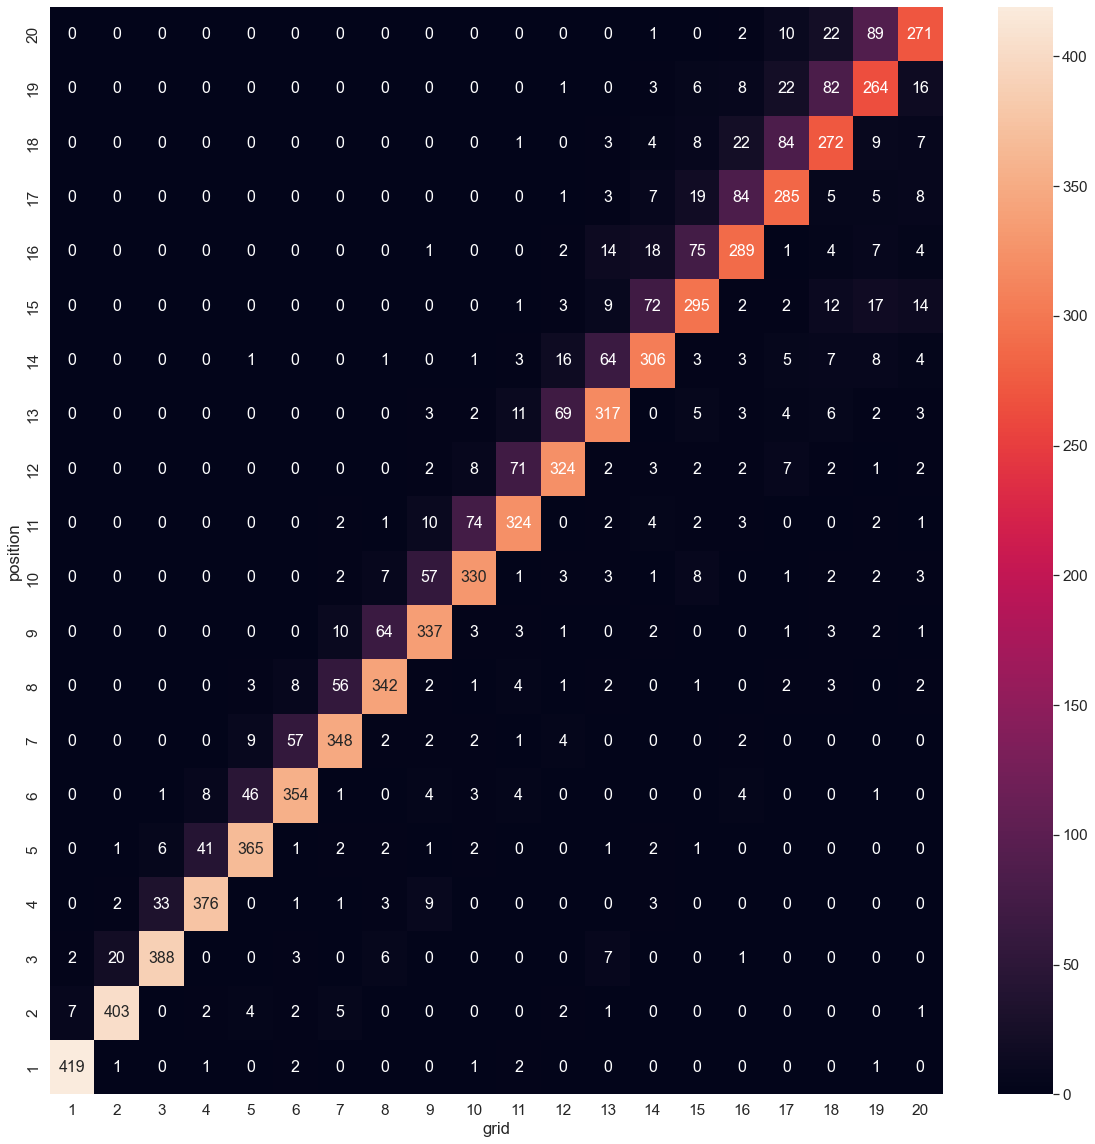

In [529]:
#1 correlation pole position vs wining the race
pole_vs_win = final_data[["grid", "position"]].copy()

#pruning the data
pole_vs_win = pole_vs_win[pole_vs_win["position"] <= 20]
pole_vs_win = pole_vs_win[(pole_vs_win["grid"] > 0) &(pole_vs_win["grid"] <= 20)]
pole_vs_win.dropna(inplace=True)

x = pole_vs_win["position"]
y = pole_vs_win["grid"]

cf_matrix = confusion_matrix(x, y)
# print(cf_matrix)
cf_matrix = pd.crosstab(x, y)
dc_cm = pd.DataFrame(cf_matrix)
sn.set(font_scale=1.4)
plt.figure(figsize=(20,20))
sn.heatmap(dc_cm, annot=True, fmt="g", annot_kws={"size": 16}, xticklabels=True, yticklabels=True)
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#2 correlation: home advantage


In [ ]:
#3 correlation

In [421]:
print(final_data.columns)

Index(['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob',
       'driver_nationality', 'raceId', 'constructorId', 'position', 'resultId',
       'number', 'grid', 'points', 'laps', 'statusId', 'constructorRef',
       'constructor', 'constructor_nationality', 'year', 'round', 'circuitId',
       'date', 'circuitRef', 'GP_name', 'location', 'country', 'driver',
       'ageDuringRace', 'Drivers'],
      dtype='object')


In [ ]:
#scraping data for driver's height 

#Python program to scrape website 
#and save quotes from website
import requests
from bs4 import BeautifulSoup
import csv
   
URL = "https://racingnews365.com/2022-f1-drivers-height-and-weight"
r = requests.get(URL)
   
soup = BeautifulSoup(r.content, 'html.parser')
table_body = soup.findChildren("tbody")
print(table_body)
for row in table_body:
    cells = row